In [1]:
# Mount Google Drive to access datasets and save progress
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Install required libraries
!pip install torch torchvision matplotlib albumentations --quiet

#**TRAIN/TEST/VAL**




In [5]:
# Define the dataset path (update path if needed)
dataset_path = "/content/drive/MyDrive/InnoFarmsAI/FNNPK"  # Adjust this path

# Folder structure
classes = ['FN', '-N', '-P', '-K']


from sklearn.model_selection import train_test_split
import shutil

# Helper function to split data into train, val, test
def stratified_split(dataset_path, classes, train_ratio=0.7, val_ratio=0.15):
    # Paths for train, val, and test datasets
    output_dirs = {
        "train": os.path.join(dataset_path, "train"),
        "val": os.path.join(dataset_path, "val"),
        "test": os.path.join(dataset_path, "test"),
    }

    # Create output directories
    for split, path in output_dirs.items():
        os.makedirs(path, exist_ok=True)
        for cls in classes:
            os.makedirs(os.path.join(path, cls), exist_ok=True)

    # Perform stratified split for each class
    for cls in classes:
        class_path = os.path.join(dataset_path, cls if cls != "FN" else "FN_augmented")
        images = os.listdir(class_path)

        # Train-validation-test split
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=val_ratio/(1-train_ratio), random_state=42)

        # Move images to respective folders
        for img_name in train_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dirs["train"], cls))
        for img_name in val_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dirs["val"], cls))
        for img_name in test_images:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dirs["test"], cls))

    print("Train-Validation-Test split completed!")
    return output_dirs

# Split the dataset
output_dirs = stratified_split(dataset_path, classes)
print("Data split into:", output_dirs)


Train-Validation-Test split completed!
Data split into: {'train': '/content/drive/MyDrive/InnoFarmsAI/FNNPK/train', 'val': '/content/drive/MyDrive/InnoFarmsAI/FNNPK/val', 'test': '/content/drive/MyDrive/InnoFarmsAI/FNNPK/test'}


#**DATALOADER**

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define the Dataset class
class LettuceDataset(Dataset):
    def __init__(self, dataset_dir, classes, transform=None):
        self.dataset_dir = dataset_dir
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for cls_idx, cls in enumerate(classes):
            class_dir = os.path.join(dataset_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):  # Ensure the file is valid
                    self.image_paths.append(img_path)
                    self.labels.append(cls_idx)  # Assign numeric labels to classes
                else:
                    print(f"Skipping invalid file: {img_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")

            # Apply transformations
            if self.transform:
                image = self.transform(image)

            # Get label
            label = self.labels[idx]

            # Calculate average RGB intensities (before normalization)
            rgb_target = image.mean(dim=(1, 2))  # Mean across width and height for each channel

            return image, (label, rgb_target)
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            raise

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = LettuceDataset(os.path.join(output_dirs["train"]), classes, transform=train_transform)
val_dataset = LettuceDataset(os.path.join(output_dirs["val"]), classes, transform=val_test_transform)
test_dataset = LettuceDataset(os.path.join(output_dirs["test"]), classes, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print("DataLoaders created successfully!")


DataLoaders created successfully!


#**MODEL ARCHITECTURE**

In [7]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet50_Weights

# Define the multi-task model
class MultiTaskResNetModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(MultiTaskResNetModel, self).__init__()

        # Load a pre-trained ResNet backbone
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Remove the original classification head (fc layer)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove the original classifier

        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to reduce overfitting
        )

        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128, num_classes)  # Number of classes
            # No nn.Softmax, as CrossEntropyLoss expects logits
        )

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128, 3),  # Predicting R, G, B values
            nn.Sigmoid()  # Ensures outputs are in [0, 1]
        )

    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone(x)

        # Shared layers
        shared_features = self.shared_fc(features)

        # Task-specific heads
        classification_output = self.classification_head(shared_features)
        regression_output = self.regression_head(shared_features)

        return classification_output, regression_output

# Instantiate the model
num_classes = 4  # FN, -N, -P, -K
model = MultiTaskResNetModel(num_classes=num_classes)

# Print model summary
print(model)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.7MB/s]


MultiTaskResNetModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

#**TRAINING**

In [10]:
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torch.utils.data import DataLoader

# Device initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
model = model.to(device)

# Define Loss Functions
classification_criterion = nn.CrossEntropyLoss()  # For classification
regression_criterion = nn.MSELoss()  # For regression

# Unfreeze the last few layers of ResNet
for param in model.backbone.layer4.parameters():
    param.requires_grad = True

# Normalize RGB targets to [0, 1] in your dataset if not already done

# Define DataLoader with batch size
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Dynamic Loss Weights (Uncertainty-Based)
log_sigma1 = torch.nn.Parameter(torch.tensor(0.0, device=device))
log_sigma2 = torch.nn.Parameter(torch.tensor(0.0, device=device))

# Create parameter groups for optimizer
decay = []
no_decay = []
for name, param in model.named_parameters():
    if 'bias' in name or 'bn' in name or 'BatchNorm' in name:
        no_decay.append(param)
    else:
        decay.append(param)

# Include log_sigma parameters without weight decay
optimizer = optim.AdamW([
    {'params': decay, 'weight_decay': 1e-4},
    {'params': no_decay, 'weight_decay': 0.0},
    {'params': [log_sigma1, log_sigma2], 'weight_decay': 0.0}
], lr=1e-4)

# Define scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training configuration
num_epochs = 25
best_val_accuracy = 0.0  # To track the best validation accuracy
best_model_path = "/content/drive/MyDrive/InnoFarmsAI/FNNPK/best_model.pth"  # File to save the best model

# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    classification_train_loss = 0.0
    regression_train_loss = 0.0
    correct, total = 0, 0

    for images, (labels, rgb_targets) in tqdm(train_loader):
        images, labels, rgb_targets = images.to(device), labels.to(device), rgb_targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        classification_output, regression_output = model(images)

        # Compute losses
        classification_loss = classification_criterion(classification_output, labels)
        regression_loss = regression_criterion(regression_output, rgb_targets)

        # Dynamic weighting
        loss = (
            torch.exp(-log_sigma1) * classification_loss +
            torch.exp(-log_sigma2) * regression_loss +
            (log_sigma1 + log_sigma2)
        )

        # Backward pass and optimization
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        classification_train_loss += classification_loss.item()
        regression_train_loss += regression_loss.item()

        _, predicted = torch.max(classification_output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    avg_classification_train_loss = classification_train_loss / len(train_loader)
    avg_regression_train_loss = regression_train_loss / len(train_loader)

    print(f"Train Loss: {train_losses[-1]:.4f}, Classification Loss: {avg_classification_train_loss:.4f}, Regression Loss: {avg_regression_train_loss:.4f}, Accuracy: {train_accuracies[-1]:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    classification_val_loss = 0.0
    regression_val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, (labels, rgb_targets) in val_loader:
            images, labels, rgb_targets = images.to(device), labels.to(device), rgb_targets.to(device)
            classification_output, regression_output = model(images)
            classification_loss = classification_criterion(classification_output, labels)
            regression_loss = regression_criterion(regression_output, rgb_targets)
            loss = (
                torch.exp(-log_sigma1) * classification_loss +
                torch.exp(-log_sigma2) * regression_loss +
                (log_sigma1 + log_sigma2)
            )
            val_loss += loss.item()
            classification_val_loss += classification_loss.item()
            regression_val_loss += regression_loss.item()
            _, predicted = torch.max(classification_output, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    avg_classification_val_loss = classification_val_loss / len(val_loader)
    avg_regression_val_loss = regression_val_loss / len(val_loader)

    print(f"Validation Loss: {val_losses[-1]:.4f}, Classification Loss: {avg_classification_val_loss:.4f}, Regression Loss: {avg_regression_val_loss:.4f}, Accuracy: {val_accuracies[-1]:.2f}%")

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with accuracy: {best_val_accuracy:.2f}%")

    # Step the scheduler
    scheduler.step(val_losses[-1])

print(f"\nTraining complete. Best validation accuracy: {best_val_accuracy:.2f}%")
print(f"Best model saved at: {best_model_path}")


Using device: cuda

Epoch 1/25


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Train Loss: 1.7381, Classification Loss: 1.3236, Regression Loss: 0.4148, Accuracy: 57.30%
Validation Loss: 1.6314, Classification Loss: 1.2868, Regression Loss: 0.3452, Accuracy: 71.79%
New best model saved with accuracy: 71.79%

Epoch 2/25


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Train Loss: 1.6117, Classification Loss: 1.2446, Regression Loss: 0.3679, Accuracy: 59.55%
Validation Loss: 1.5220, Classification Loss: 1.1904, Regression Loss: 0.3326, Accuracy: 74.36%
New best model saved with accuracy: 74.36%

Epoch 3/25


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Train Loss: 1.4590, Classification Loss: 1.1063, Regression Loss: 0.3538, Accuracy: 71.91%
Validation Loss: 1.4047, Classification Loss: 1.0824, Regression Loss: 0.3237, Accuracy: 71.79%

Epoch 4/25


100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Train Loss: 1.3334, Classification Loss: 0.9807, Regression Loss: 0.3540, Accuracy: 74.72%
Validation Loss: 1.3090, Classification Loss: 0.9807, Regression Loss: 0.3299, Accuracy: 69.23%

Epoch 5/25


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Train Loss: 1.1959, Classification Loss: 0.8666, Regression Loss: 0.3308, Accuracy: 73.60%
Validation Loss: 1.2128, Classification Loss: 0.8708, Regression Loss: 0.3437, Accuracy: 69.23%

Epoch 6/25


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Train Loss: 1.0486, Classification Loss: 0.7275, Regression Loss: 0.3227, Accuracy: 79.78%
Validation Loss: 1.1492, Classification Loss: 0.7914, Regression Loss: 0.3598, Accuracy: 69.23%

Epoch 7/25


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Train Loss: 0.9216, Classification Loss: 0.6073, Regression Loss: 0.3164, Accuracy: 80.34%
Validation Loss: 1.0533, Classification Loss: 0.6881, Regression Loss: 0.3675, Accuracy: 69.23%

Epoch 8/25


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Train Loss: 0.7584, Classification Loss: 0.4698, Regression Loss: 0.2914, Accuracy: 85.39%
Validation Loss: 0.8847, Classification Loss: 0.5125, Regression Loss: 0.3750, Accuracy: 74.36%

Epoch 9/25


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Train Loss: 0.6647, Classification Loss: 0.3970, Regression Loss: 0.2714, Accuracy: 86.52%
Validation Loss: 0.7514, Classification Loss: 0.3810, Regression Loss: 0.3740, Accuracy: 84.62%
New best model saved with accuracy: 84.62%

Epoch 10/25


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Train Loss: 0.5825, Classification Loss: 0.3067, Regression Loss: 0.2805, Accuracy: 93.82%
Validation Loss: 0.6661, Classification Loss: 0.2970, Regression Loss: 0.3738, Accuracy: 89.74%
New best model saved with accuracy: 89.74%

Epoch 11/25


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Train Loss: 0.5075, Classification Loss: 0.2350, Regression Loss: 0.2784, Accuracy: 95.51%
Validation Loss: 0.6737, Classification Loss: 0.3078, Regression Loss: 0.3717, Accuracy: 89.74%

Epoch 12/25


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Train Loss: 0.3933, Classification Loss: 0.1135, Regression Loss: 0.2871, Accuracy: 99.44%
Validation Loss: 0.7832, Classification Loss: 0.4029, Regression Loss: 0.3866, Accuracy: 94.87%
New best model saved with accuracy: 94.87%

Epoch 13/25


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Train Loss: 0.3972, Classification Loss: 0.1183, Regression Loss: 0.2873, Accuracy: 99.44%
Validation Loss: 0.8585, Classification Loss: 0.4945, Regression Loss: 0.3710, Accuracy: 94.87%

Epoch 14/25


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Train Loss: 0.3866, Classification Loss: 0.0872, Regression Loss: 0.3090, Accuracy: 98.31%
Validation Loss: 0.7414, Classification Loss: 0.4122, Regression Loss: 0.3378, Accuracy: 97.44%
New best model saved with accuracy: 97.44%

Epoch 15/25


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Train Loss: 0.3369, Classification Loss: 0.0921, Regression Loss: 0.2560, Accuracy: 97.75%
Validation Loss: 0.6523, Classification Loss: 0.3383, Regression Loss: 0.3236, Accuracy: 97.44%

Epoch 16/25


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Train Loss: 0.2754, Classification Loss: 0.0376, Regression Loss: 0.2499, Accuracy: 100.00%
Validation Loss: 0.6628, Classification Loss: 0.3602, Regression Loss: 0.3127, Accuracy: 97.44%

Epoch 17/25


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Train Loss: 0.3045, Classification Loss: 0.0600, Regression Loss: 0.2570, Accuracy: 98.88%
Validation Loss: 0.6640, Classification Loss: 0.3709, Regression Loss: 0.3036, Accuracy: 97.44%

Epoch 18/25


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Train Loss: 0.3095, Classification Loss: 0.0327, Regression Loss: 0.2898, Accuracy: 99.44%
Validation Loss: 0.6609, Classification Loss: 0.3726, Regression Loss: 0.2994, Accuracy: 97.44%

Epoch 19/25


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Train Loss: 0.2895, Classification Loss: 0.0315, Regression Loss: 0.2718, Accuracy: 99.44%
Validation Loss: 0.6810, Classification Loss: 0.4000, Regression Loss: 0.2924, Accuracy: 97.44%

Epoch 20/25


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Train Loss: 0.3356, Classification Loss: 0.0935, Regression Loss: 0.2561, Accuracy: 96.07%
Validation Loss: 0.6549, Classification Loss: 0.3788, Regression Loss: 0.2880, Accuracy: 97.44%

Epoch 21/25


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Train Loss: 0.2617, Classification Loss: 0.0332, Regression Loss: 0.2434, Accuracy: 98.88%
Validation Loss: 0.6437, Classification Loss: 0.3726, Regression Loss: 0.2833, Accuracy: 97.44%

Epoch 22/25


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Train Loss: 0.2839, Classification Loss: 0.0545, Regression Loss: 0.2444, Accuracy: 98.88%
Validation Loss: 0.5958, Classification Loss: 0.3252, Regression Loss: 0.2833, Accuracy: 97.44%

Epoch 23/25


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Train Loss: 0.2500, Classification Loss: 0.0245, Regression Loss: 0.2411, Accuracy: 99.44%
Validation Loss: 0.5953, Classification Loss: 0.3265, Regression Loss: 0.2818, Accuracy: 97.44%

Epoch 24/25


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Train Loss: 0.2706, Classification Loss: 0.0293, Regression Loss: 0.2570, Accuracy: 99.44%
Validation Loss: 0.6058, Classification Loss: 0.3370, Regression Loss: 0.2820, Accuracy: 97.44%

Epoch 25/25


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Train Loss: 0.2419, Classification Loss: 0.0186, Regression Loss: 0.2396, Accuracy: 99.44%
Validation Loss: 0.5786, Classification Loss: 0.3191, Regression Loss: 0.2732, Accuracy: 97.44%

Training complete. Best validation accuracy: 97.44%
Best model saved at: /content/drive/MyDrive/InnoFarmsAI/FNNPK/best_model.pth


#**VISUALIZATION**

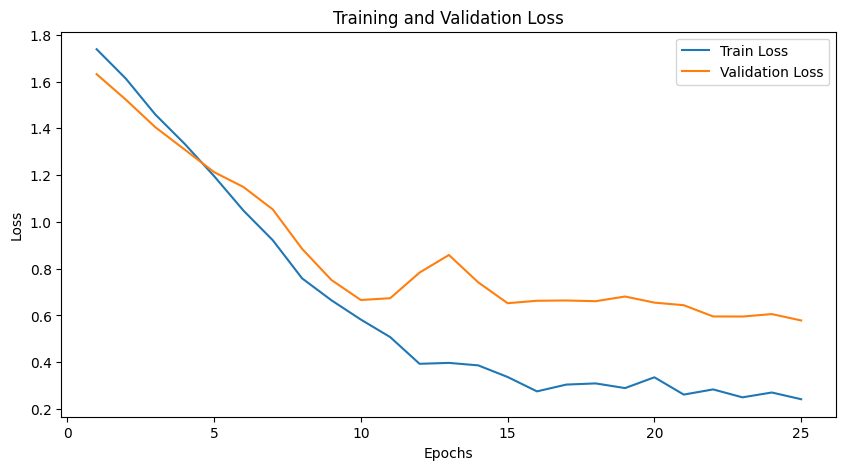

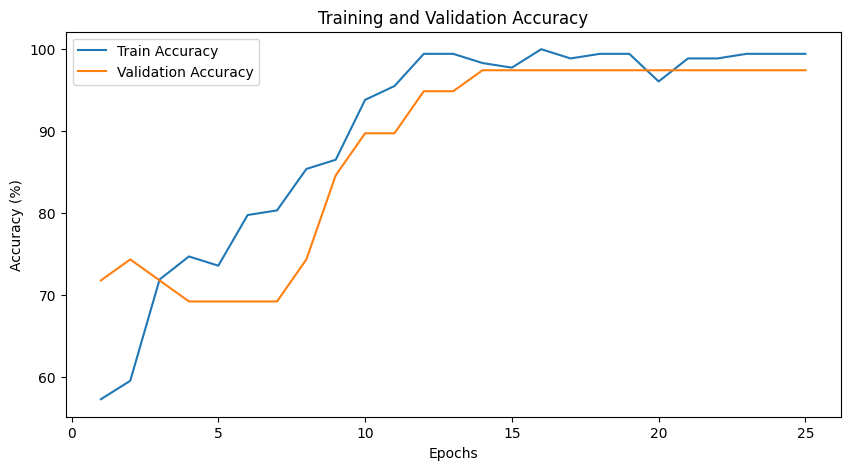

In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

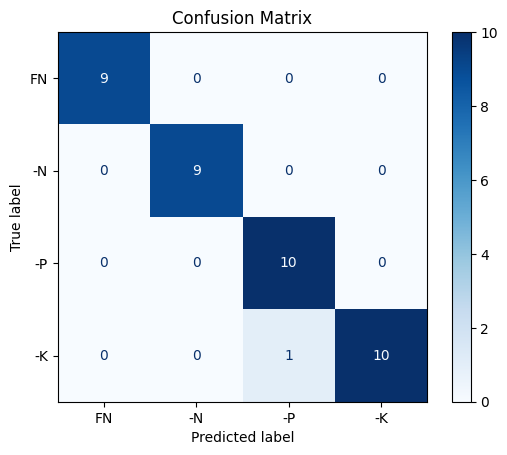

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, (labels, _) in val_loader:
        images, labels = images.to(device), labels.to(device)
        classification_output, _ = model(images)
        _, predicted = torch.max(classification_output, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [15]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

          FN       1.00      1.00      1.00         9
          -N       1.00      1.00      1.00         9
          -P       0.91      1.00      0.95        10
          -K       1.00      0.91      0.95        11

    accuracy                           0.97        39
   macro avg       0.98      0.98      0.98        39
weighted avg       0.98      0.97      0.97        39



In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

true_values, predicted_values = [], []
with torch.no_grad():
    for images, (_, rgb_targets) in val_loader:
        images, rgb_targets = images.to(device), rgb_targets.to(device)
        _, regression_output = model(images)
        true_values.extend(rgb_targets.cpu().numpy())
        predicted_values.extend(regression_output.cpu().numpy())

# Compute metrics
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print(f"Regression Performance Metrics:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R² Score: {r2:.4f}")


Regression Performance Metrics:
MAE: 0.4178, MSE: 0.2751, R² Score: 0.0949


#**INFERENCE**

In [11]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for images, (labels, rgb_targets) in test_loader:
        images, labels, rgb_targets = images.to(device), labels.to(device), rgb_targets.to(device)
        classification_output, regression_output = model(images)
        classification_loss = classification_criterion(classification_output, labels)
        regression_loss = regression_criterion(regression_output, rgb_targets)
        loss = (
            torch.exp(-log_sigma1) * classification_loss +
            torch.exp(-log_sigma2) * regression_loss +
            (log_sigma1 + log_sigma2)
        )
        test_loss += loss.item()
        _, predicted = torch.max(classification_output, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {test_accuracy:.2f}%")


<ipython-input-11-2c1ffb61022b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.5216, Accuracy: 94.87%
